In [292]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.regularizers import l1
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
import pathlib
import cv2
import os 
import PIL
import PIL.Image
import io
%matplotlib inline

In [1]:
pwd

'/Users/Ethan/Documents/Documents/Documents - Ethan’s MacBook Pro/python/chest_xray'

In [4]:
data_dir = '/Users/Ethan/Documents/Documents/Documents - Ethan’s MacBook Pro/python/chest_xray/train'
classes = []

def listDir(dir):
    labels = os.listdir(dir)
    for label in labels:
        classes.append(label)

if __name__ == '__main__':
    listDir(data_dir)

classes.remove('.DS_Store')
        
 

def create_training_data(classes):
    # build train dataset
    img_array_dict = dict()
    for root, dirs, files in os.walk(data_dir):
        print(os.path.basename(root))
        my_train_key = os.path.basename(root)
        if my_train_key in classes:
            path = os.path.join(data_dir, my_train_key) # path to normal or pneumonia directory
            training_imgs = []   
            for img in os.listdir(path):# go through images
                try:
                    img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                    # Decrease height&width to so all images have the same fixed dimension
                    new_img_array = cv2.resize(img_array, (224,224),interpolation = cv2.INTER_NEAREST) 
                    # Normalize pixel values to be between 0 and 1
                    new_img_array = new_img_array.astype(float,copy=False)/255 
                    training_imgs.append(new_img_array)
                except Exception as e:
                    raise e  
            img_array_dict[my_train_key] = training_imgs           
    
    return img_array_dict

ds = create_training_data(classes)

train
PNEUMONIA
NORMAL


In [5]:
l = 0
for key, value in ds.items():
    l = l + len(value) 
    print(key) 
    print(value)  
print(l) ## Total of 5232 training images ##
print(ds['PNEUMONIA'][1])

PNEUMONIA
NORMAL
5232
[[0.46666667 0.45098039 0.38823529 ... 0.71764706 0.59215686 0.72156863]
 [0.42352941 0.45098039 0.43137255 ... 0.70196078 0.63529412 0.67843137]
 [0.49411765 0.49019608 0.45490196 ... 0.71764706 0.6627451  0.72156863]
 ...
 [0.06666667 0.06666667 0.06666667 ... 0.09411765 0.09411765 0.09411765]
 [0.07058824 0.07058824 0.06666667 ... 0.09411765 0.09411765 0.09411765]
 [0.0627451  0.0627451  0.06666667 ... 0.09411765 0.09411765 0.09411765]]


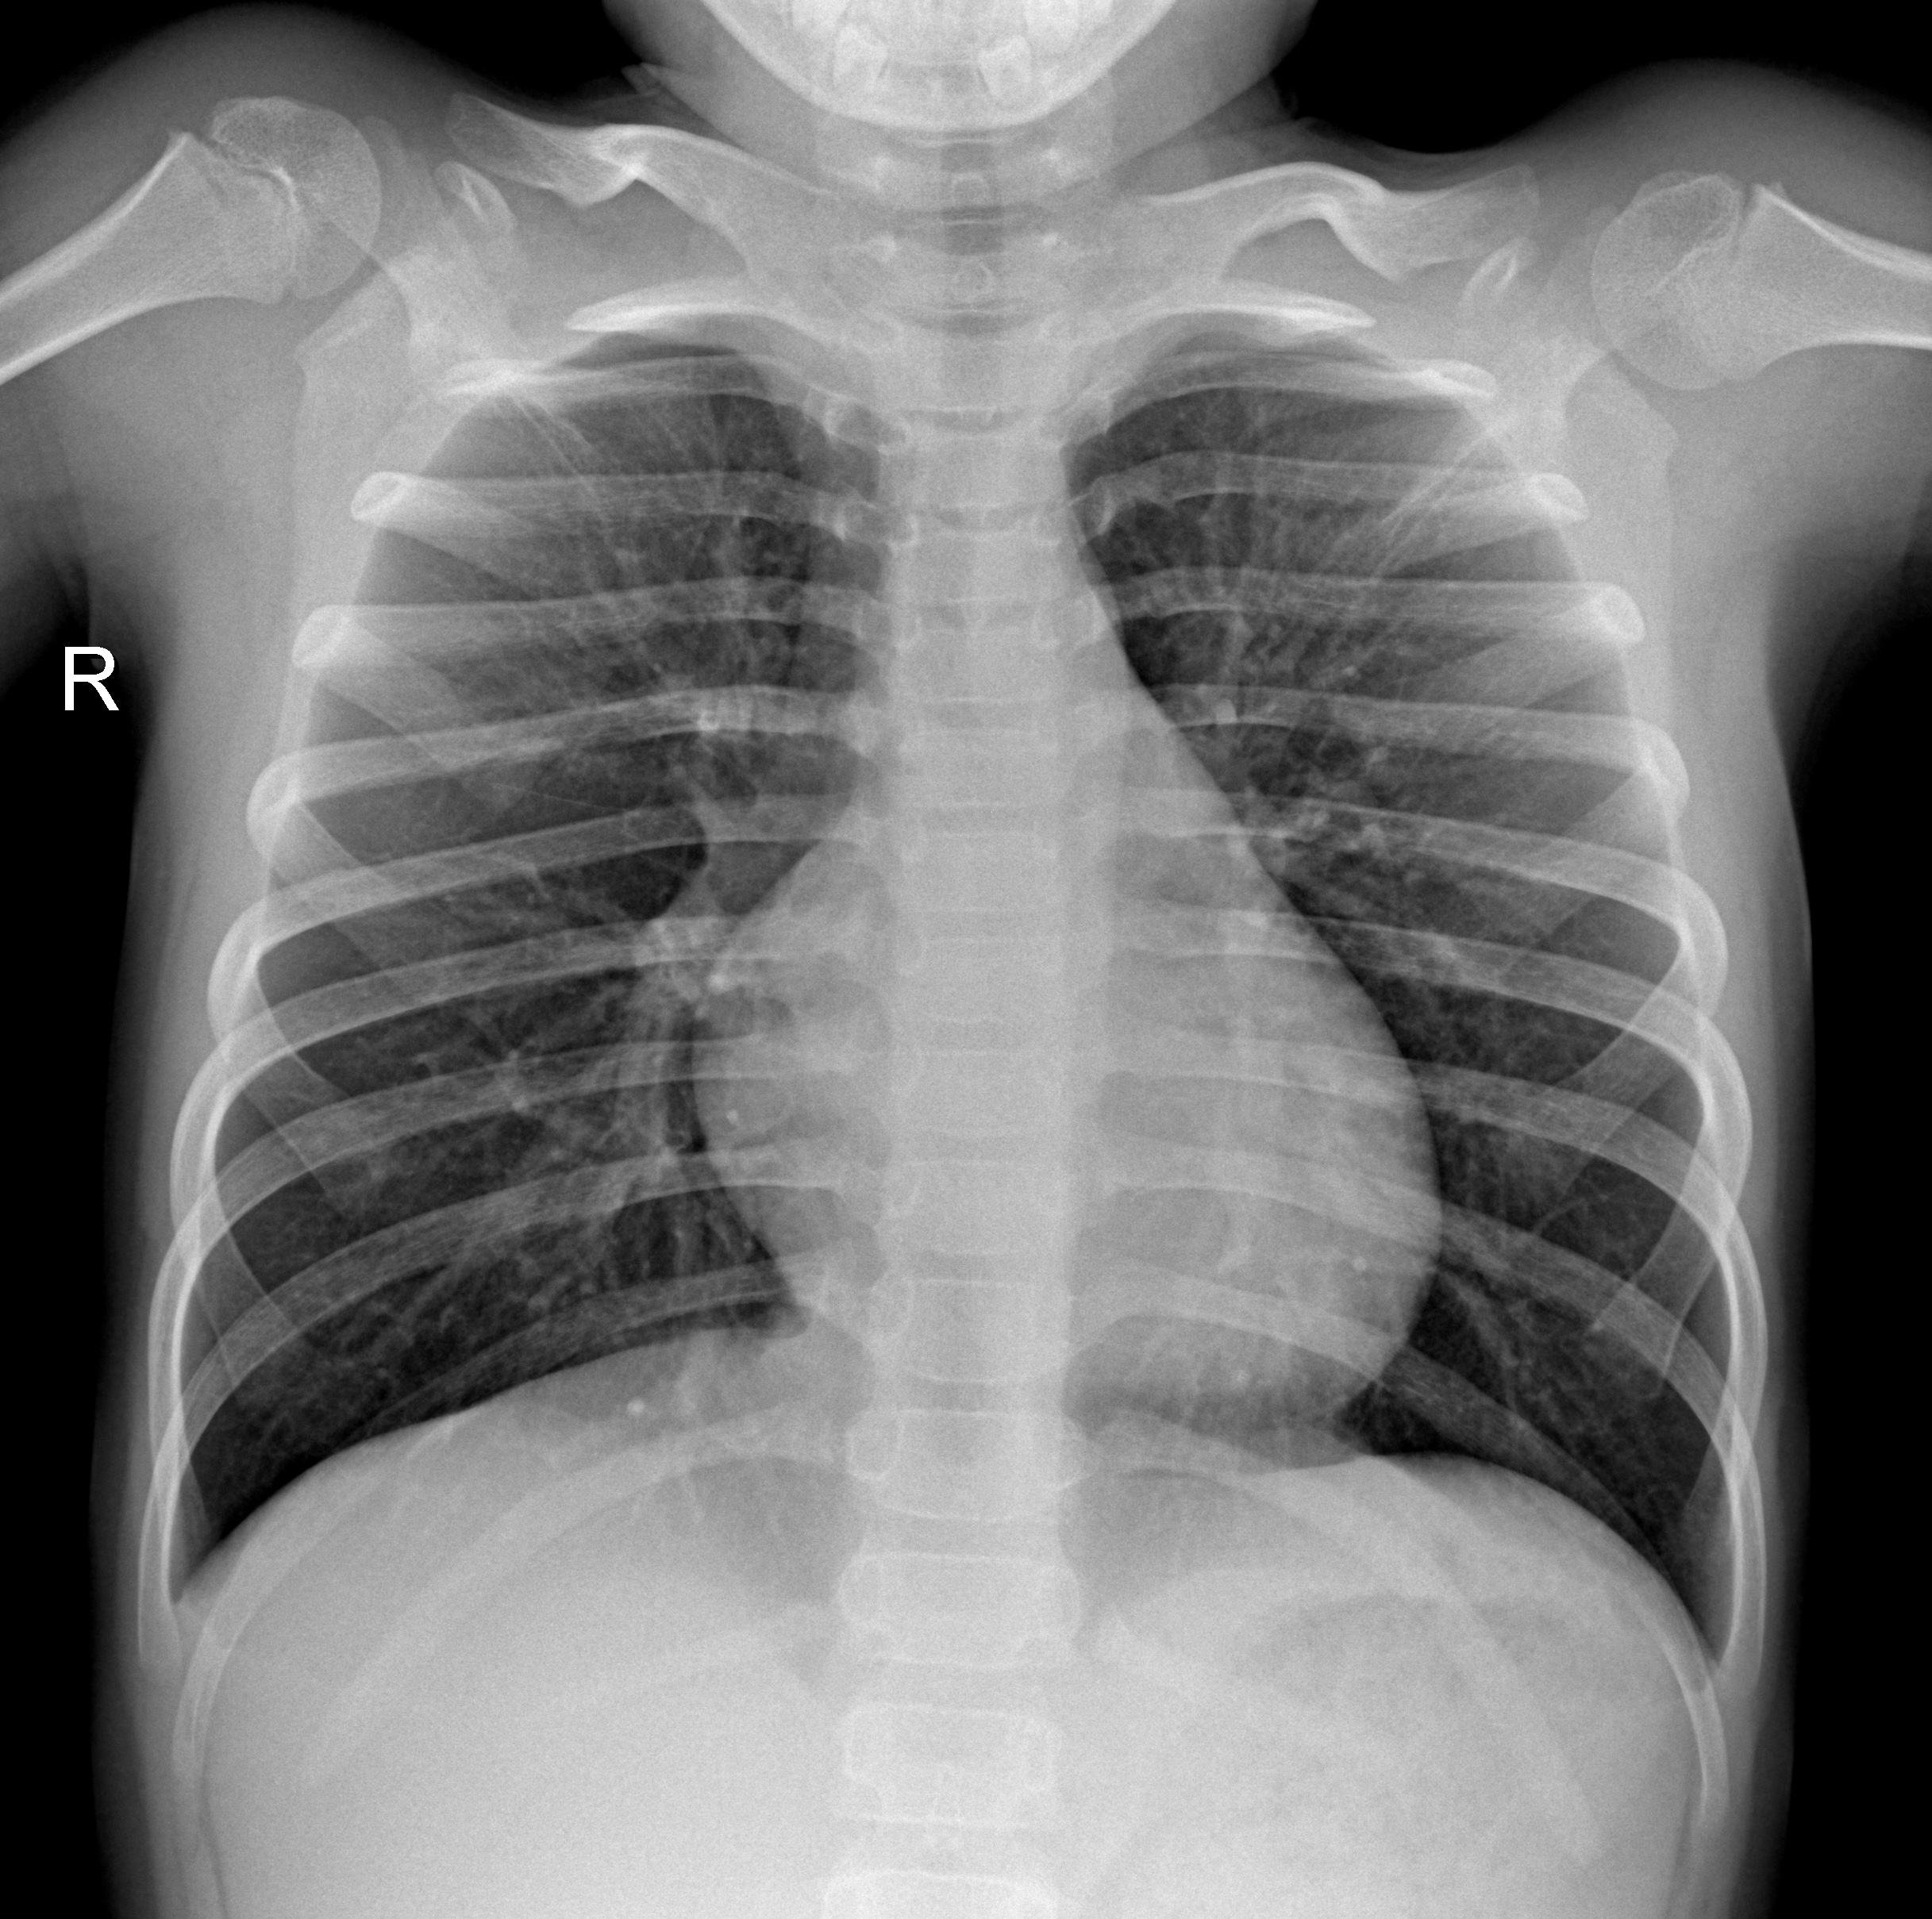

In [13]:
#X-ray of 'NORMAL' patient

from IPython.display import Image
normal_img = display(Image(filename='/Users/Ethan/Documents/Documents/Documents - Ethan’s MacBook Pro/python/chest_xray/train/NORMAL/NORMAL-28501-0001.jpeg',
                           width=250,height=250))

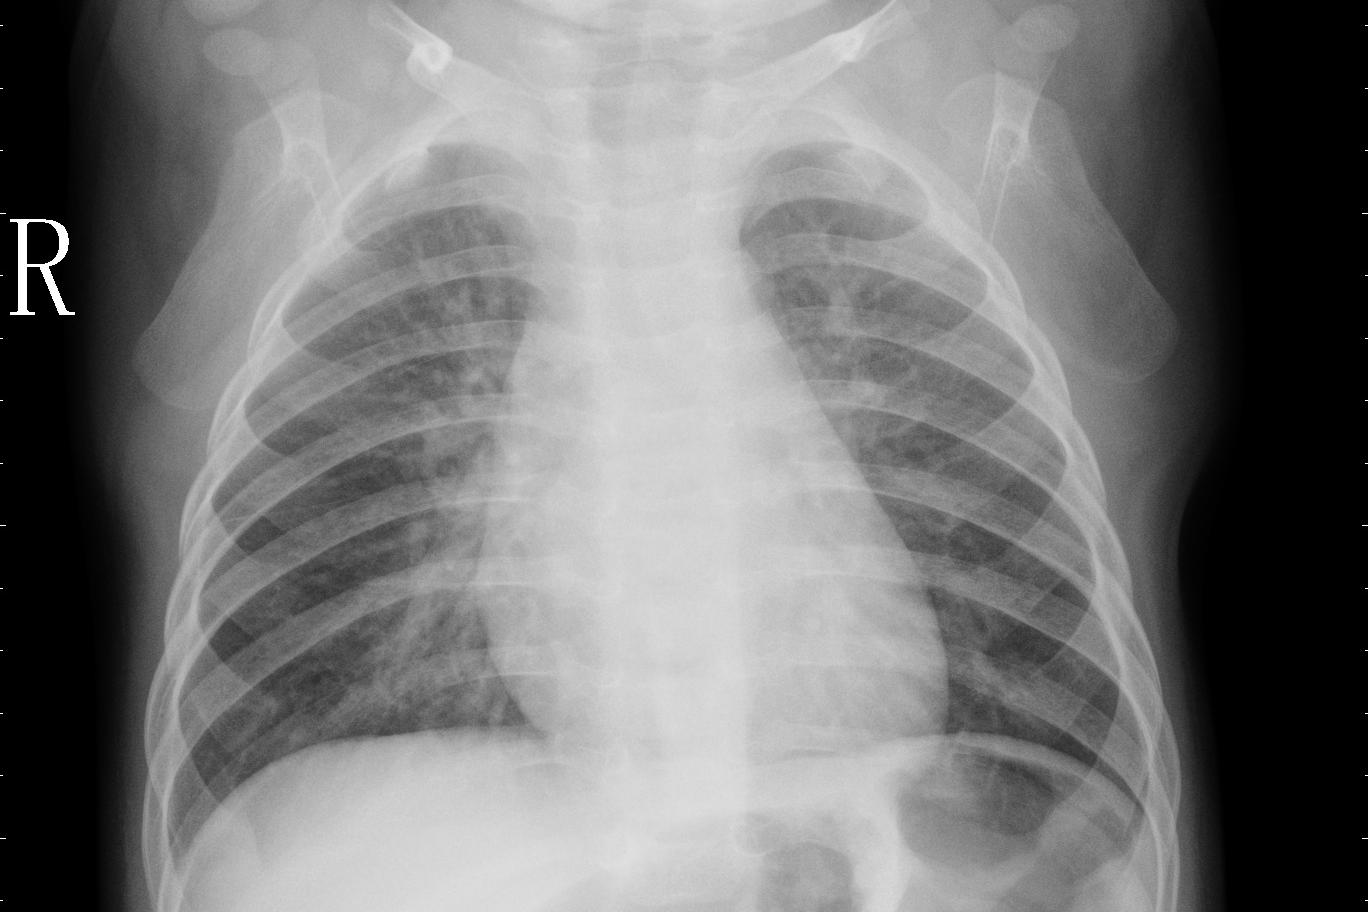

In [14]:
# X-ray showing the presence of virus, it is easy to see the presence of bright white air in the chest region

# Observe white region in bottom of x-ray (diaphragm) - potential for noise

pneumonia_img = display(Image(filename='/Users/Ethan/Documents/Documents/Documents - Ethan’s MacBook Pro/python/chest_xray/train/PNEUMONIA/VIRUS-516591-0003.jpeg'
                              ,width=250,height=250))

In [6]:
# Modules to further pre-process image data and apply transformations

from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening
from skimage.util import img_as_ubyte
from skimage import io

In [7]:
# Create training set of binary images and a training set of binary images with removed diaphragms 
 
def create_binary_set(ds,remove_diaphragm=False):
    binary_img_dict = dict()
    for category, img_array  in ds.items():
        binary_train_imgs = []
        for binary_img in img_array: 
            binary_img = binary_img * 255
            binary_img = binary_img.astype(np.uint8)
            median = cv2.medianBlur(binary_img,3) #Apply morphological transformation
            thresh = 128
            max_val = 255
            binary_img = (binary_img > thresh) * max_val
            if remove_diaphragm:
                binary_img[175:, 25:] = 0
            binary_img = binary_img.astype(float,copy=False)
            binary_img = binary_img / 255
            binary_train_imgs.append(binary_img)
            
        binary_img_dict[category] = binary_train_imgs
    
    return binary_img_dict

ds_binary = create_binary_set(ds)

ds_binary_crop = create_binary_set(ds,True)

In [296]:
l = 0
for key, value in ds_binary.items():
    l = l + len(value) 
    print(key) 
    #print(value) # access data for each label 
print(l)

PNEUMONIA
NORMAL
5232


In order to create a legitimate second training set, we will assume an average cropping size for our images.
- Notice the size (length+width) of all the diaphragms in the x-rays. We will estimate that from 180 on the y-axis and below, this is where the top of the diaphragm protrudes - potential for noise

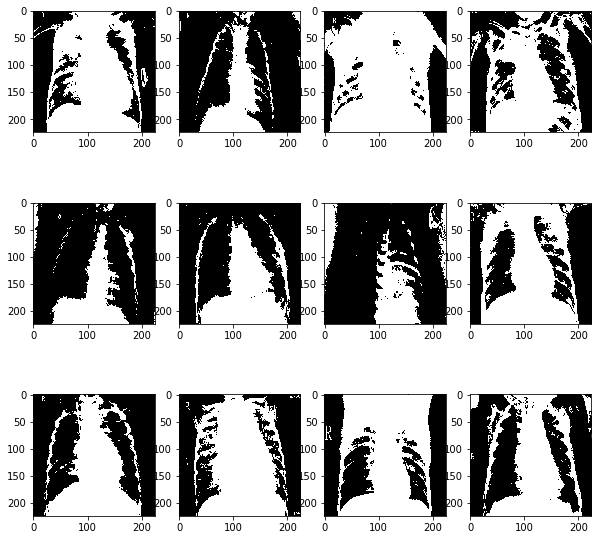

In [18]:
# We will train the convolutional neural network twice, and pick the training set that results in the best accuracy

# The subplot below is of strictly binarized images with diaphragm regions still present

plt.figure(figsize=(10,10))
l = 3
w = 4
for i in range(l*w):
    plt.subplot(l,w,i+1)
    plt.grid(False)
    plt.imshow(ds_binary['PNEUMONIA'][i], cmap='gray')
    plt.axis('on')
plt.show()

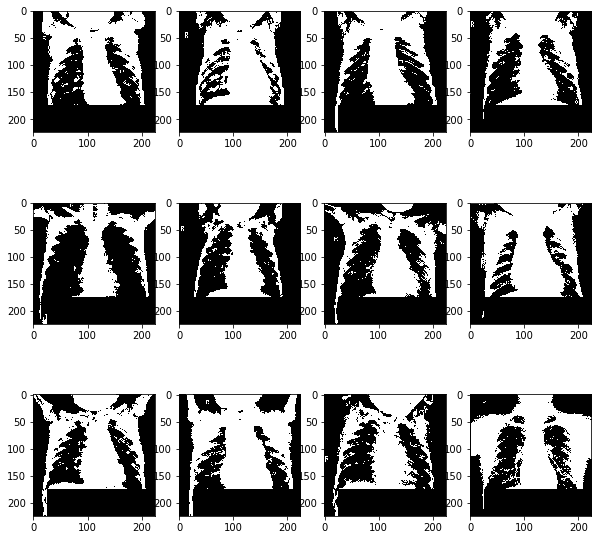

In [19]:
plt.figure(figsize=(10,10))
l = 3
w = 4
for i in range(l*w):
    plt.subplot(l,w,i+1)
    plt.grid(False)
    plt.imshow(ds_binary_crop['NORMAL'][i], cmap='gray')
    plt.axis('on')
plt.show()

In [9]:
# Generate test set

test_dir = '/Users/Ethan/Documents/Documents/Documents - Ethan’s MacBook Pro/python/chest_xray/test'
classes = []

def listDir(dir):
    labels = os.listdir(dir)
    for label in labels:
        classes.append(label)

if __name__ == '__main__':
    listDir(data_dir)

classes.remove('.DS_Store')
        
 

def create_test_data(classes):
    img_array_dict = dict()
    for root, dirs, files in os.walk(test_dir):
        print(os.path.basename(root))
        my_test_key = os.path.basename(root)
        if my_test_key in classes:
            path = os.path.join(test_dir, my_test_key)
            test_imgs = []   
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                    new_img_array = cv2.resize(img_array, (224,224),interpolation = cv2.INTER_NEAREST)
                    new_img_array = new_img_array.astype(float,copy=False)/255 
                    test_imgs.append(new_img_array)
                except Exception as e:
                      raise e  
            img_array_dict[my_test_key] = test_imgs           
    
    return img_array_dict

test_ds = create_test_data(classes)

test
PNEUMONIA
NORMAL


In [12]:
# Generate data to be used for models to make predictions on

prediction_dir = '/Users/Ethan/Documents/Documents/Documents - Ethan’s MacBook Pro/python/chest_xray predict/test/'
classes = []

def listDir(dir):
    labels = os.listdir(dir)
    for label in labels:
        classes.append(label)

if __name__ == '__main__':
    listDir(prediction_dir)

classes.remove('COVID19')
        
 

def create_prediction_data(classes):
    img_array_dict = dict()
    for root, dirs, files in os.walk(prediction_dir):
        print(os.path.basename(root))
        my_predict_key = os.path.basename(root)
        if my_predict_key in classes:
            path = os.path.join(prediction_dir, my_predict_key)
            predict_imgs = []   
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                    new_img_array = cv2.resize(img_array, (224,224),interpolation = cv2.INTER_NEAREST)
                    new_img_array = new_img_array.astype(float,copy=False)/255 
                    predict_imgs.append(new_img_array)
                except Exception as e:
                      raise e  
            img_array_dict[my_predict_key] = predict_imgs           
    
    return img_array_dict

prediction_ds = create_prediction_data(classes)


COVID19
PNEUMONIA
NORMAL


PNEUMONIA
NORMAL
1172


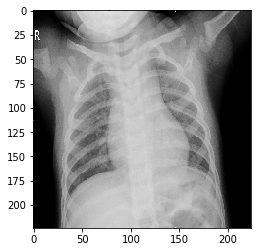

In [40]:
l = 0
for key, value in prediction_ds.items():
    l = l + len(value) 
    print(key) 
    #print(value) 
print(l) 
plt.imshow(prediction_ds['NORMAL'][0],cmap='gray')

In [99]:
# convert prediction data to np arrays

predictmap = {'NORMAL':[1.,0.],'PNEUMONIA':[0.,1.]}

x_predict = []
predict_labels = []

for label, img_array in prediction_ds.items():
    for img in img_array:
        x_predict.append(img)
        predict_labels.append(predictmap[label])
        
x_predict = np.array(x_predict)
predict_labels = np.array(predict_labels)

In [100]:
x_predict = np.reshape(x_predict,(1172, 224, 224,1))

In [252]:
# Assigning our data to be stored in numpy arrays to satisfy keras API requirements

ymap = {'NORMAL':[1.,0.],'PNEUMONIA':[0.,1.]}

x = []
y = []

for label, img_array in ds_binary.items():
    if label == 'PNEUMONIA':
        # Create even distribution of data between classes
        indices = np.random.choice(range(len(img_array)),len(ds_binary['NORMAL']))
        img_array = np.array(img_array)[indices]
    for img in img_array:
        x.append(img)
        y.append(ymap[label])
        
x = np.array(x)
y = np.array(y)

In [253]:
x.shape

(2698, 224, 224)

In [255]:
x = np.reshape(x, (2698, 224, 224,1))

In [254]:
y.shape

(2698, 2)

In [317]:
def cnn_model():
    
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(224,224,1)))

    model.add(layers.Conv2D(32, (3,3),kernel_regularizer=l1(0.01),bias_regularizer=l1(0.01)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3)))
    model.add(layers.Activation('relu'))                        
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3),kernel_regularizer=l1(0.01),bias_regularizer=l1(0.01)))
    model.add(layers.Activation('relu'))                        
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Conv2D(128, (3,3)))
    model.add(layers.Activation('relu'))                        
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Flatten()) 
    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dense(2,activation='sigmoid'))

    return model

In [318]:
model = cnn_model()

In [306]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
activation_4 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_5 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 128)      

In [307]:
early = EarlyStopping(monitor='val_loss',patience=5)
lr_reduce = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=4)


adm = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()

# Configure learning process for training.
model.compile(optimizer=adm,
              loss=loss,
              metrics=['accuracy'])

# Train our CNN
model1 = model.fit(x=x, y=y, epochs=20, batch_size=64, 
                    validation_split=0.2,shuffle=True,callbacks=[early,lr_reduce])

Train on 2158 samples, validate on 540 samples
Epoch 1/20
2158/2158 [==============================] - 328s 152ms/sample - loss: 13.4376 - acc: 0.6576 - val_loss: 5.6612 - val_acc: 0.8176
Epoch 2/20
2158/2158 [==============================] - 327s 152ms/sample - loss: 2.3854 - acc: 0.9036 - val_loss: 0.9753 - val_acc: 0.8806
Epoch 3/20
2158/2158 [==============================] - 318s 147ms/sample - loss: 0.6639 - acc: 0.9147 - val_loss: 0.6509 - val_acc: 0.8602
Epoch 4/20
2158/2158 [==============================] - 323s 150ms/sample - loss: 0.5253 - acc: 0.9124 - val_loss: 0.5104 - val_acc: 0.8880
Epoch 5/20
2158/2158 [==============================] - 329s 153ms/sample - loss: 0.4380 - acc: 0.9284 - val_loss: 0.4919 - val_acc: 0.8898
Epoch 6/20
2158/2158 [==============================] - 323s 150ms/sample - loss: 0.3906 - acc: 0.9310 - val_loss: 0.6011 - val_acc: 0.8380
Epoch 7/20
2158/2158 [==============================] - 321s 149ms/sample - loss: 0.4157 - acc: 0.9270 - val_los

In [308]:
model.save("Model 1-32x3-CNN_v4.hdf5")

In [45]:
from sklearn.metrics import confusion_matrix

In [309]:
# This code taken from https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

predIdxs = model.predict(x_predict, batch_size = 8)

predIdxs = np.argmax(predIdxs, axis=1)

cm = confusion_matrix(predict_labels.argmax(axis=1),predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[ 36 281]
 [  0 855]]
acc: 0.7602
sensitivity: 0.1136
specificity: 1.0000


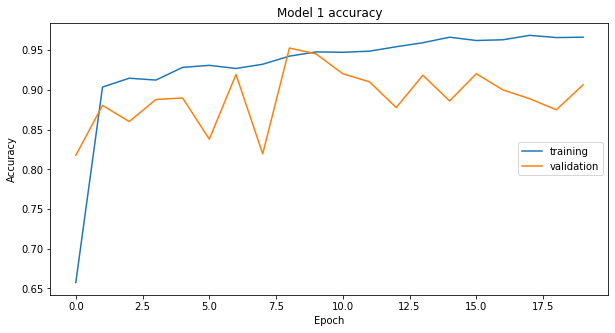

In [310]:
plt.figure(figsize=(10,5))
plt.plot(model1.history['acc'])
plt.plot(model1.history['val_acc'])
plt.title('Model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='center right')
plt.show()

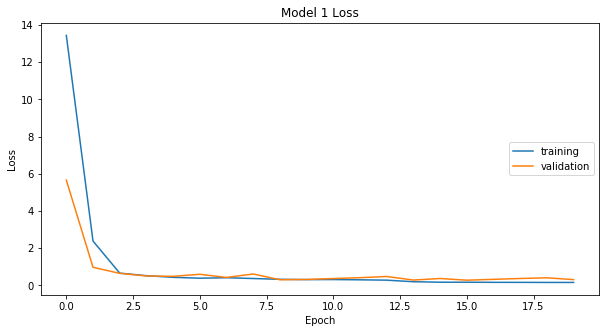

In [311]:
plt.figure(figsize=(10,5))
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='center right')
plt.show()

Evaluate model

In [267]:
targetmap = {'NORMAL':[1.,0.],'PNEUMONIA':[0.,1.]}

x_test = []
test_labels = []

for label, img_array in test_ds.items():
    for img in img_array:
        x_test.append(img)
        test_labels.append(targetmap[label])
        
x_test = np.array(x_test)
test_labels = np.array(test_labels)

In [268]:
x_test = np.reshape(x_test, (624, 224, 224,1))

In [312]:
print('Evaluate on test data')
scores = model.evaluate(x_test, test_labels)
print('test loss, test acc:', scores)

Evaluate on test data
624/624 [==============================] - 49s 79ms/sample - loss: 1.2205 - acc: 0.6322
test loss, test acc: [1.2204914368115938, 0.63221157]


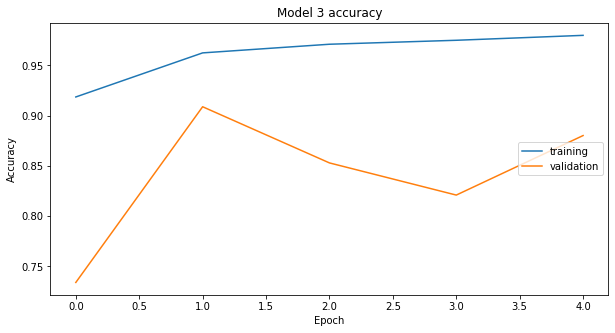

In [43]:
# Accuracy and loss plots of previously trained models

plt.figure(figsize=(10,5))
plt.plot(pure_binary_train.history['acc'])
plt.plot(pure_binary_train.history['val_acc'])
plt.title('Model 2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='center right')
plt.show()

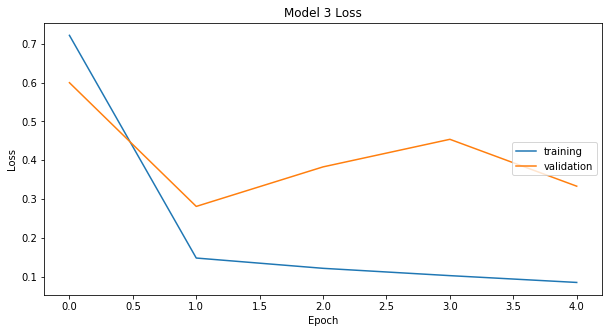

In [44]:
plt.figure(figsize=(10,5))
plt.plot(pure_binary_train.history['loss'])
plt.plot(pure_binary_train.history['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='center right')
plt.show()

In [322]:
# Exercise to observe what the croppped-binarize dataset would yield during prediction


predIdx = cropped_model.predict(x_test, batch_size = 8)

predIdx = np.argmax(predIdx, axis=1)

cm = confusion_matrix(test_labels.argmax(axis=1),predIdx)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[ 27 207]
 [ 19 371]]
acc: 0.6378
sensitivity: 0.1154
specificity: 0.9513


Various morphological transformations were performed at the outset of this project to test
performance of image preprocessing algorithms

- The cells below show how applying 'closing' (dilation and erosion) tightens up foreground pixels 
by removing small dark regions. 

- Once small dark gaps were closed, the following step is to apply 'opening' which is fixated on the white pixel population near the diaphragm

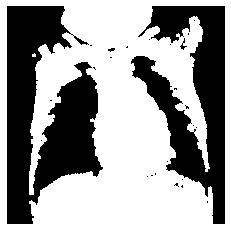

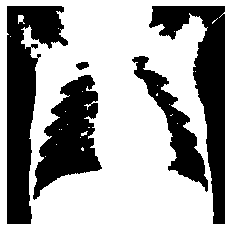

'\nmedian = cv2.medianBlur(img_array,3)\nret, th = cv2.threshold(median, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)\nerosion = cv2.erode(th,kernel,iterations=1)\n\nplt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))\nplt.axis("off")\nplt.show()\n\nplt.imshow(cv2.cvtColor(th, cv2.COLOR_BGR2RGB))\nplt.axis("off")\nplt.show()\nprint(th)\n\n\nplt.imshow(cv2.cvtColor(erosion, cv2.COLOR_BGR2RGB))\nplt.axis("off")\nplt.show()\n'

In [598]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))

#opened = cv2.morphologyEx(binary_train_imgs[0],cv2.MORPH_OPEN,kernel)
open_img = binary_opening(binary_train_imgs[1000],kernel) # I like opened better

plt.imshow(open_img, cmap='gray')
plt.axis("off")
plt.show()

close_img = binary_closing(binary_train_imgs[1000],kernel)
plt.imshow(close_img, cmap='gray')
plt.axis("off")
plt.show()
'''
median = cv2.medianBlur(img_array,3)
ret, th = cv2.threshold(median, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
erosion = cv2.erode(th,kernel,iterations=1)

plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

plt.imshow(cv2.cvtColor(th, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
print(th)


plt.imshow(cv2.cvtColor(erosion, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
'''

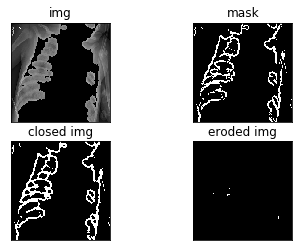

5527


In [327]:
_, mask = cv2.threshold(img_array,127,255,cv2.THRESH_BINARY)

#img_array[mask == 255] = 0
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

close = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernel)
erosion = cv2.erode(close,kernel,iterations=2)
#opened = cv2.morphologyEx(close,cv2.MORPH_OPEN,kernel)

titles = ['img','mask','closed img','eroded img']
images = [img_array,mask,close,erosion]

for i in range(4):
    plt.subplot(2 , 2, i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()
# find number of white pixels in binary image 
pixels = cv2.countNonZero(mask)
print(pixels)

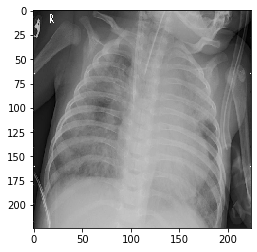

TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [287]:
#img[mask == 255] = 0
'''
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
erosion = cv2.erode(mask,kernel,iterations=10)
plt.imshow(cv2.cvtColor(erosion, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

img[erosion == 255] = 0
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

closing = cv2.morphologyEx(img,cv2.MORPH_CLOSE,kernel,iterations=4)
plt.imshow(cv2.cvtColor(closing,cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
'''
plt.imshow(img_array,cmap='gray')
plt.show()
#plt.imshow(mask,cmap='gray')
#plt.show()

image_bw = 255*(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) > 5).astype('uint8')

kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))

mask2 = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel1)
mask2 = cv2.morphologyEx(mask2, cv2.MORPH_OPEN, kernel2)

mask2 = np.stack([mask2, mask2],axis=2) / 255
mask2 = cv2.resize(mask2, (IMG_SIZE,IMG_SIZE),interpolation=cv2.INTER_NEAREST)
mask2 = mask2.reshape(mask2.shape[0],mask2.shape[1])
print(mask2.shape)
#out = img * mask2
print(img_array.shape)

plt.imshow(mask2,cmap='gray')
plt.show()
# for pixels near the 0 valued pixels in the closed image, convert those pixels to 0 as well and smooth their boundary or contour
# turn bright pixels to 0 and map back to original img